In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets
from nilearn import plotting
from matplotlib import pyplot as plt

In [3]:
import sys
sys.path.append('/home/sebastian/PycharmProjects/metis')
from metis import connectivity
from metis import subtype

In [4]:
cwd = './metis_tutorial/'

## Get data to play with

In [5]:
# Get an atlas
atlas_data = datasets.fetch_atlas_basc_multiscale_2015()
atlas_img = nib.load(atlas_data.scale007)
atlas = atlas_img.get_data().astype(int)
mask = nib.load(atlas_data.scale007).get_data().astype(bool)
# Define variables
n_sub = 6
n_vox = mask.sum()
n_net = len(np.unique(atlas[atlas!=0]))

In [6]:
# Get sample data
sample_data = datasets.fetch_abide_pcp(data_dir=cwd, 
                                       n_subjects=n_sub, 
                                       pipeline='niak', 
                                       DX_GROUP=2)
covariates = ['SITE_ID', 'AGE_AT_SCAN', 'func_mean_fd']
pheno = pd.DataFrame({key:list(sample_data.phenotypic.field(key)) for key in covariates})

## Generate connectivity estimates

In [7]:
# Make a stack of seed maps
stack = np.zeros((n_net, n_sub, n_vox))
for sid in range(n_sub):
    stack[:, sid, :] = connectivity.sca(sample_data.func_preproc[sid], mask, atlas)

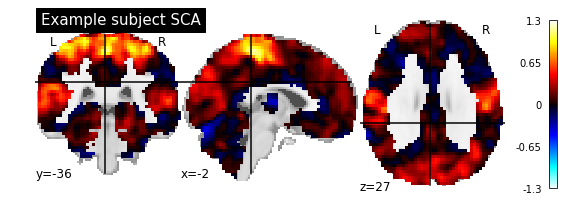

In [8]:
# Take a look at the maps
vol = np.zeros(mask.shape)
vol[mask] = stack[2, 0, :]
img = nib.Nifti1Image(vol, affine=atlas_img.affine)
plotting.plot_stat_map(img, title='Example subject SCA');

In [9]:
# Regress nuisance covariates from these maps
resid = np.zeros((n_net, n_sub, n_vox))
for nid in range(n_net):
    residual, gm = subtype.nuisance_regression(stack[nid, ...], 
                                            pheno,
                                            'SITE_ID+AGE_AT_SCAN+func_mean_fd')
    resid[nid, ...] = residual

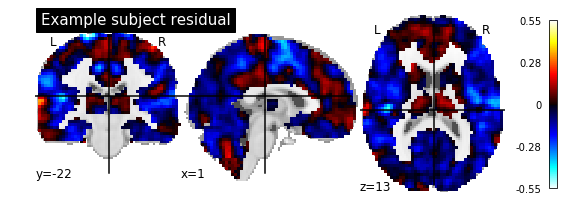

In [10]:
# Take another look at the maps
# Take a look at the maps
vol2 = np.zeros(mask.shape)
vol2[mask] = resid[2, 0, :]
img2 = nib.Nifti1Image(vol2, affine=atlas_img.affine)
plotting.plot_stat_map(img2, title='Example subject residual');

## Conduct subtype analysis

In [11]:
# Generate subtypes
n_sbt = 2
sbt_dict = dict()
weights = np.zeros((n_net, n_sub, n_sbt))
for nid in range(n_net):
    # Generate the subtype
    (sbt, part, order) = subtype.subtype(resid[nid, ...], n_sbt, mode='dist')
    # Store the subtypes in a dictionary
    sbt_dict[nid] = {key:val for key, val in zip(['sbt', 'part', 'order'], (sbt, part, order))}
    # Generate the weights
    weights[nid, ...] = subtype.subtype_weights(resid[nid, ...], sbt)

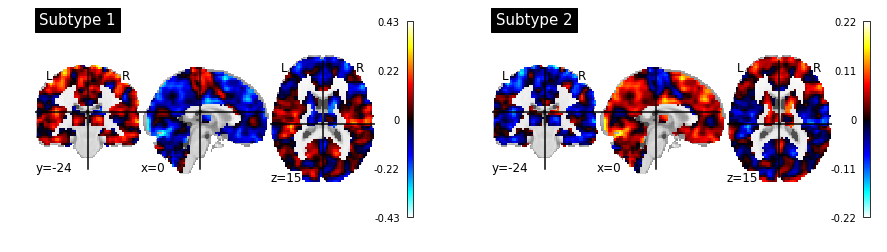

In [12]:
# Take a look at the subtype maps
f = plt.figure(figsize=(15,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

vol_sbt1 = np.zeros(mask.shape)
vol_sbt1[mask] = sbt_dict[2]['sbt'][:, 0]
img_sbt1 = nib.Nifti1Image(vol_sbt1, affine=atlas_img.affine)

vol_sbt2 = np.zeros(mask.shape)
vol_sbt2[mask] = sbt_dict[2]['sbt'][:, 1]
img_sbt2 = nib.Nifti1Image(vol_sbt2, affine=atlas_img.affine)

plotting.plot_stat_map(img_sbt1, axes=ax1, title='Subtype 1');
plotting.plot_stat_map(img_sbt2, axes=ax2, title='Subtype 2');

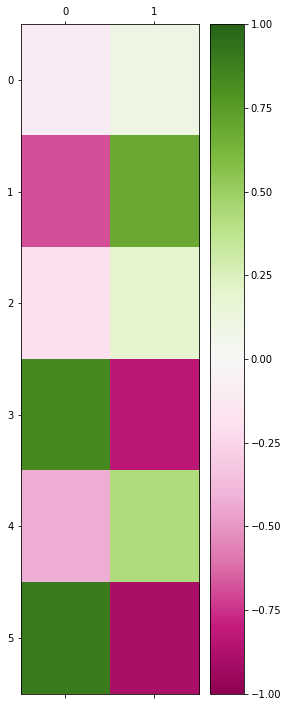

In [13]:
# Take a look at the weights
plt.matshow(weights[2, ...], aspect='auto', vmin=-1, vmax=1, cmap=plt.cm.PiYG)
plt.colorbar()

## Store your new subtypes

In [14]:
for nid in sbt_dict.keys():
    # Imaging data
    for sid in range(n_sbt):
        v = np.zeros(mask.shape)
        v[mask] = sbt_dict[nid]['sbt'][:, sid]
        img = nib.Nifti1Image(v, affine=atlas_img.affine, header=atlas_img.header)
        nib.save(img, os.path.join(cwd, 'net_{}_sbt_{}.nii.gz'.format(nid+1, sid+1)))
    # Array data
    np.savez(os.path.join(cwd, 'net_{}_sbt_{}.npz'.format(nid+1, sid+1)), 
             part=sbt_dict[nid]['part'], 
             order=sbt_dict[nid]['order'],
             weights=weights[nid, ...])

These arrays and maps can then be used for further analysis.